# Loading data

In [18]:
#!/bin/env python3.7

# load standard python modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss
from modules.perf_eval import get_perf_stats, linear_classifier_test 
from modules.fcn_linear import fully_connected_linear_network

# importing the torch modules
from modules.my_jet_augs import rotate_jets, distort_jets, rescale_pts, crop_jets, translate_jets, collinear_fill_jets

# import args from extargs.py file
import My_extargs as args

#starting counter
t0 = time.time()

# initialise logfile
logfile = open( args.logfile, "a" )
print( "logfile initialised"   )

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )
print( "device: " + str( device )    )

#loading in data ------------------------------------------------------------

#coverter functions -----------------------------

def pT(px,py):
    pT = np.sqrt( px**2 + py**2 )
    return pT

# Calculate pseudorapidity of pixel entries
def eta(pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate phi of the pixel entries (in range [-pi,pi])
# phis are returned in radians, np.arctan(0,0)=0 -> zero constituents set to -np.pi
def phi (px, py):
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

#doing the convertions
def converter(data_path,num_jets):

    data_frame = pd.read_hdf(data_path, key='table', start=0, stop=num_jets)
    #give names
    max_const = args.n_constit
    feat_list =  ["E","PX","PY","PZ"] 
    cols = ["{0}_{1}".format(feature,constit) for feature in feat_list for constit in range(max_const)]
    #reshape
    vec4 = np.expand_dims(data_frame[cols],axis=-1).reshape(-1, len(feat_list), max_const)
    #getting p_vec and E
    E  = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    # get pT,eta,phi
    pTs = pT(pxs,pys)
    etas = eta(pTs,pzs)
    phis = phi(pxs,pys)
    #get them together
    jet_data = np.stack([pTs,etas,phis],axis = 1)
    labels = data_frame["is_signal_new"].to_numpy()
    return jet_data , labels

#defining classes ------------------------------------------

class My_Dataset(Dataset):
    def __init__(self, training_path , validation_path, test_path, usage, transform=None, target_transform=None):
        #getting data
        num_jets = 1e3 #args.n_jets
        train_data , train_labels = converter(training_path,int( num_jets) )
        val_data , val_labels = converter(validation_path, int(num_jets*args.ratio) )
        test_data, test_labels = converter(test_path,int(num_jets*args.ratio))

        train_data = torch.Tensor(train_data)

        if usage== "training" :
            self.labels = train_labels
            self.data = train_data
        elif usage=="validation":
            self.labels = val_labels
            self.data = val_data
        elif usage=="testing":
            self.labels = test_labels
            self.data = test_data
        else:
            print("check usage!")

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.labels[idx]

        return data, label
    
#starting training loader --------------------------------------


training_set = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"training")

dl_training = DataLoader(training_set,batch_size=args.batch_size, shuffle=True)

t1 = time.time()
#print(dl_training,  flush=True, file=logfile  )
print( "time taken to load and preprocess data: "+str( np.round( t1-t0, 2 ) ) + " seconds"    )


#initializing the network 
input_dim = 3 

net = Transformer( input_dim, args.model_dim, args.output_dim, args.n_heads, args.dim_feedforward, args.n_layers, args.learning_rate, args.n_head_layers, dropout=0.1, opt=args.opt )
# send network to device
net.to( device )

"""
# set up results directory -----------------------------------------------------------
base_dir = "/remote/gpu05/rueschkamp/outputs_from_queue/" 
expt_tag = "Mytry1"
expt_dir = base_dir + "My_experiments/" + expt_tag + "/"
# check if experiment already exists
if os.path.isdir(expt_dir):
    sys.exit("ERROR: experiment already exists, don't want to overwrite it by mistake")
else:
    os.makedirs(expt_dir)
    """



logfile initialised
device: cuda
time taken to load and preprocess data: 0.09 seconds


'\n# set up results directory -----------------------------------------------------------\nbase_dir = "/remote/gpu05/rueschkamp/outputs_from_queue/" \nexpt_tag = "Mytry1"\nexpt_dir = base_dir + "My_experiments/" + expt_tag + "/"\n# check if experiment already exists\nif os.path.isdir(expt_dir):\n    sys.exit("ERROR: experiment already exists, don\'t want to overwrite it by mistake")\nelse:\n    os.makedirs(expt_dir)\n    '

## Testing Rotations

In [3]:
def rotate_jets_0to2pi(batch):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    dim 1 ordering: (pT, eta, phi)
    Output: batch of jets rotated independently in eta-phi, same shape as input
    '''
    device = batch.device
    batch_size = batch.size(0)

    rot_angle = torch.linspace(0, 2 * np.pi, batch_size)
    c = torch.cos(rot_angle)
    s = torch.sin(rot_angle)
    o = torch.ones_like(rot_angle)
    z = torch.zeros_like(rot_angle)

    #print(o.shape)

    rot_matrix = torch.stack([
    torch.stack([o, z, z], dim=0),
    torch.stack([z, c, -s], dim=0),
    torch.stack([z, s, c], dim=0)], dim=1) # (3, 3, batch_size]

    #print(rot_matrix[:,:,0])

    return torch.einsum('ijk,lji->ilk', batch, rot_matrix)

In [4]:
for i, (data, labels) in enumerate(dl_training):
    original_batch = data
    break

In [6]:
print(original_batch.shape)

original_jet = original_batch[0]

print(original_jet.shape)

standard_batch = original_jet.unsqueeze(0).repeat(128, 1, 1)

rotated_batch = rotate_jets_0to2pi(standard_batch)

with torch.no_grad():
        
    x_i = rotated_batch

    #x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) #this should not be a thing lol WTF ______-----____

    #print(x_i.shape)

    x_i = x_i.transpose(1,2)

    point_on_sphere = net(x_i)

                #normalise it!
    point_on_sphere = F.normalize(point_on_sphere, dim=-1)

    mapped_rotated_jets = torch.stack(point_on_sphere.unsqueeze())





torch.Size([128, 3, 50])
torch.Size([3, 50])


RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_mm

## Testing mask


### Loop 

In [26]:
# THE TRAINING LOOP -----------------------------------------------------------

print( "starting training loop, running for " + str( args.n_epochs ) + " epochs"    )
print( "---"    )

losses = []

# the loop
#for epoch in range( args.n_epochs ):
for epoch in range( 21 ):
    # initialise timing stats
    te0 = time.time()
    
    # initialise lists to store batch stats
    loss_align_e = []
    loss_uniform_e = []
    losses_e = []

    # initialise timing stats
    td1 = 0
    td2 = 0
    print("epoch: ",epoch)

    # the inner loop goes through the dataset batch by batch
    # augmentations of the jets are done on the fly
    for i, (data, labels) in enumerate(dl_training):
        net.optimizer.zero_grad()
        x_i = data
        x_i = x_i.to(device)
        
        time1 = time.time()
        # print(x_i.shape) # checking what Tensor is fed into the augmentations
        #x_i = rotate_jets( x_i )

        x_j = x_i.clone()
        if args.rot:
            x_j = rotate_jets( x_j )
        time2 = time.time()
        """
        if args.cf:
            x_j = collinear_fill_jets( x_j )
            x_j = collinear_fill_jets( x_j ) #Why two times?
        time3 = time.time()

        if args.ptd:
            x_j = distort_jets( x_j, strength=args.ptst, pT_clip_min=args.ptcm )
        time4 = time.time()

        if args.trs:
            x_j = translate_jets( x_j, width=args.trsw )
            x_i = translate_jets( x_i, width=args.trsw ) # Why are both translated?
        time5 = time.time()
        """

        x_i = rescale_pts( x_i )
        x_j = rescale_pts( x_j )


        x_i = x_i.transpose(1,2)
        x_j = x_j.transpose(1,2)

        z_i  = net(x_i,use_continuous_mask=True) #dim: x_i = torch.Size([104, 50, 3]) and z_i = torch.Size([104, 1000])
        z_j = net(x_j,use_continuous_mask=True)

        # compute the loss, back-propagate, and update scheduler if required
        loss = contrastive_loss( z_i, z_j, args.temperature ).to( device )
        loss.backward()
        net.optimizer.step()
        losses_e.append( loss.detach().cpu().numpy() )
        
        time9 = time.time()

    loss_e = np.mean( np.array( losses_e ) )
    losses.append( loss_e )


#np.save("/remote/gpu05/rueschkamp/outputs_from_queue/CLR/clr_losses.npy", losses )

print(x_j.shape )
print(z_j.shape )

t2= time.time()

print( "JETCLR TRAINING DONE, time taken: " + str( np.round( t2-t1 , 2 ) )    )

starting training loop, running for 100 epochs
---
epoch:  0
epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
epoch:  16
epoch:  17
epoch:  18
epoch:  19
epoch:  20
torch.Size([104, 50, 3])
torch.Size([104, 1000])
JETCLR TRAINING DONE, time taken: 466.28


tensor(0)
torch.Size([128, 3, 50])
torch.Size([3, 50])
torch.Size([128, 1000])
torch.Size([1000])
torch.Size([128])


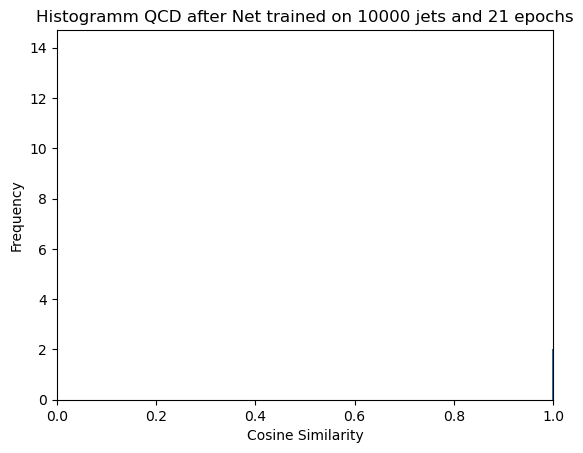

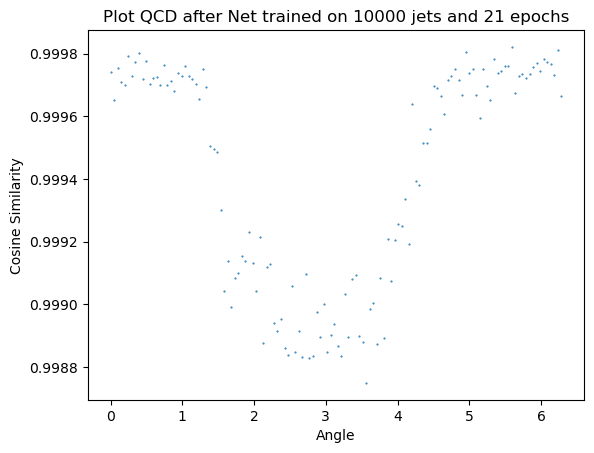

tensor(0)
torch.Size([128, 3, 50])
torch.Size([3, 50])
torch.Size([128, 1000])
torch.Size([1000])
torch.Size([128])


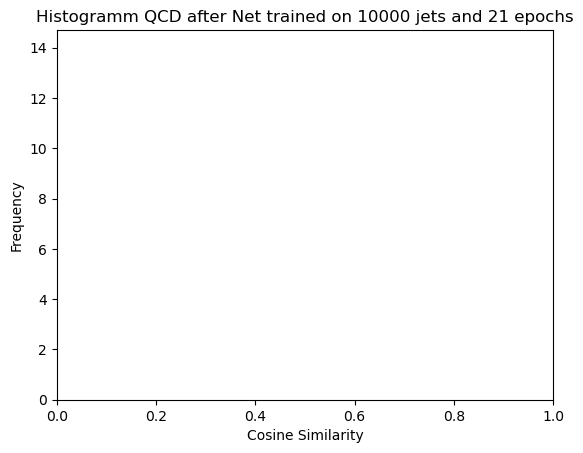

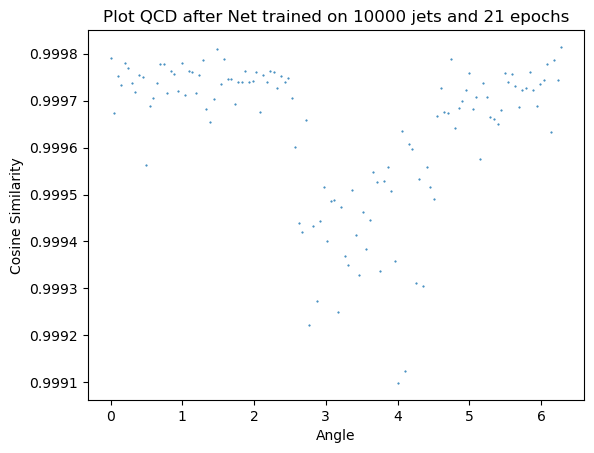

200
(3, 50)
torch.Size([1, 3, 50])


In [27]:
# Testing the Mapping of rotations

def rotate_jets_0to2pi(batch):
    '''
    Input: batch of jets, shape (batchsize, 3, n_constit)
    dim 1 ordering: (pT, eta, phi)
    Output: batch of jets rotated independently in eta-phi, same shape as input
    '''
    device = batch.device
    batch_size = batch.size(0)

    rot_angle = torch.linspace(0, 2 * np.pi, batch_size)
    c = torch.cos(rot_angle)
    s = torch.sin(rot_angle)
    o = torch.ones_like(rot_angle)
    z = torch.zeros_like(rot_angle)

    #print(o.shape)

    rot_matrix = torch.stack([
    torch.stack([o, z, z], dim=0),
    torch.stack([z, c, -s], dim=0),
    torch.stack([z, s, c], dim=0)], dim=1) # (3, 3, batch_size]

    #print(rot_matrix[:,:,0])

    return torch.einsum('ijk,lji->ilk', batch, rot_matrix)




for i, (data, labels) in enumerate(dl_training):
    original_batch = data
    print(labels[0])
    break

print(original_batch.shape)

original_jet = original_batch[0]

print(original_jet.shape)

standard_batch = original_jet.unsqueeze(0).repeat(128, 1, 1)

rotated_batch = rotate_jets_0to2pi(standard_batch)

with torch.no_grad():
        
    x_i = standard_batch
    x_j = rotated_batch


    x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) 
    x_j =torch.Tensor( x_j ).transpose(1,2).to( device ) 

    #print(x_i.shape)

    point_on_sphere_i = net(x_i)
    point_on_sphere_j = net(x_j)


                #normalise it!
    point_on_sphere_i = F.normalize(point_on_sphere_i, dim=-1)
    point_on_sphere_j = F.normalize(point_on_sphere_j, dim=-1)
print(point_on_sphere_j.size())
print(point_on_sphere_i[0].size())

# Calculate cosine similarity between the first jet in the batch and all the others
cos_similarities = torch.nn.functional.cosine_similarity(point_on_sphere_i[0], point_on_sphere_j, dim=1)
print(cos_similarities.size())

# Plot a histogram of the cosine similarities
plt.hist(cos_similarities.cpu().numpy(), bins=50)
plt.title("Histogramm QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Cosine Similarity')
plt.xlim(0,1)
plt.ylabel('Frequency')
plt.show()

angles = torch.linspace(0,2*np.pi,128)

# Create the plot
plt.plot(angles.cpu().numpy(), cos_similarities.cpu().numpy(), '.', markersize=1)
plt.title("Plot QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Angle')
plt.ylabel('Cosine Similarity')
plt.show()
### Now for top:
for i, (data, labels) in enumerate(dl_training):
    original_batch = data
    print(labels[2])
    break

print(original_batch.shape)

original_jet = original_batch[2]

print(original_jet.shape)

standard_batch = original_jet.unsqueeze(0).repeat(128, 1, 1)

rotated_batch = rotate_jets_0to2pi(standard_batch)

with torch.no_grad():
        
    x_i = standard_batch
    x_j = rotated_batch


    x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) 
    x_j =torch.Tensor( x_j ).transpose(1,2).to( device ) 

    #print(x_i.shape)

    point_on_sphere_i = net(x_i)
    point_on_sphere_j = net(x_j)


                #normalise it!
    point_on_sphere_i = F.normalize(point_on_sphere_i, dim=-1)
    point_on_sphere_j = F.normalize(point_on_sphere_j, dim=-1)
print(point_on_sphere_j.size())
print(point_on_sphere_i[0].size())

# Calculate cosine similarity between the first jet in the batch and all the others
cos_similarities = torch.nn.functional.cosine_similarity(point_on_sphere_i[0], point_on_sphere_j, dim=1)
print(cos_similarities.size())

# Plot a histogram of the cosine similarities
plt.hist(cos_similarities.cpu().numpy(), bins=50)
plt.title("Histogramm QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Cosine Similarity')
plt.xlim(0,1)
plt.ylabel('Frequency')
plt.show()

angles = torch.linspace(0,2*np.pi,128)

# Create the plot
plt.plot(angles.cpu().numpy(), cos_similarities.cpu().numpy(), '.', markersize=1)
plt.title("Plot QCD after Net trained on 10000 jets and 21 epochs")
plt.xlabel('Angle')
plt.ylabel('Cosine Similarity')
plt.show()
## Setting up the Data
test_set = My_Dataset(args.tr_dat_path,args.val_dat_path,args.test_dat_path,"validation")

dl_test = DataLoader(test_set, shuffle=False)

print(len(test_set))

print(test_set[0][0].shape)

# Get one batch of data
data_iter = iter(dl_test)
batch = next(data_iter)

# Get one element from the batch
element = batch[0]

# Print the shape of the element
print(element.shape)